In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qutip import *
import math

Parameters

In [2]:
# N = 10

# wc = 5.0 * 2 * math.pi
# w1 = 3.0 * 2 * math.pi
# w2 = 2.0 * 2 * math.pi

# g1 = 0.01 * 2 * math.pi
# g2 = 0.0125 * 2 * math.pi

# tlist = np.linspace(0, 100, 500)

# width = 0.5

# # resonant SQRT iSWAP gate
# T0_1 = 20
# T_gate_1 = (1*math.pi)/(4 * g1)

# # resonant iSWAP gate
# T0_2 = 60
# T_gate_2 = (2*math.pi)/(4 * g2)

In [3]:
N = 10

wc = 7.0 * 2 * math.pi
# w1 = 3.0 * 2 * math.pi
# w2 = 2.0 * 2 * math.pi
w1 = 2.0 * math.pi * 5 #e9
w2 = 2.0 * math.pi * 4.779 # e9
# g1 = 0.01 * 2 * math.pi
# g2 = 0.0125 * 2 * math.pi
g1 = 2.0 * math.pi * 5 # e6
g2 = 2.0 * math.pi * 5 #e6
dt = 500 # ns
t_gate = 49.16 # ns
t_meas = 60
t_start = 0 # ns
# tlist = np.arange(0, 100, 500)


tlist = np.linspace(0,t_meas,dt)
# print(tlist)
T0 = int((t_meas + t_start)/2)
width = 0.5

# resonant SQRT iSWAP gate
T0_1 = 20
T_gate_1 = 49.16

# resonant iSWAP gate
T0_2 = 40
T_gate_2 = 49.16

# coupling strength

# g = 2 * math.pi * 5e6 # Hz

# w1 = 2 * math.pi * 5e9

# w2 = 2 * math.pi * 4.779e9

# dt = 0.001 # ns
# t_gate = 49.16 # ns
# t_start = 5 # ns
# t_meas = 60 # ns
# t_end = t_start + t_gate
# t = np.arange(0,t_meas,dt)

Operators, Hamiltonian and initial state

In [4]:

# cavity operators
a = tensor(destroy(N), qeye(2), qeye(2))
n = a.dag() * a

# operators for qubit 1
sm1 = tensor(qeye(N), destroy(2), qeye(2))
sz1 = tensor(qeye(N), sigmaz(), qeye(2))
n1 = sm1.dag() * sm1

# oeprators for qubit 2
sm2 = tensor(qeye(N), qeye(2), destroy(2))
sz2 = tensor(qeye(N), qeye(2), sigmaz())
n2 = sm2.dag() * sm2

In [5]:

# Hamiltonian using QuTiP
Hc = a.dag() * a
H1 = - 0.5 * sz1
H2 = - 0.5 * sz2
Hc1 = g1 * (a.dag() * sm1 + a * sm1.dag())
Hc2 = g2 * (a.dag() * sm2 + a * sm2.dag())

H = wc * Hc + w1 * H1 + w2 * H2 + Hc1 + Hc2 

In [6]:

H

Quantum object: dims = [[10, 2, 2], [10, 2, 2]], shape = (40, 40), type = oper, isherm = True
Qobj data =
[[-30.72163456   0.           0.         ...   0.           0.
    0.        ]
 [  0.          -0.69429198   0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.69429198 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 395.14638238   0.
    0.        ]
 [  0.           0.           0.         ...   0.         396.53496633
    0.        ]
 [  0.           0.           0.         ...   0.           0.
  426.56230891]]

In [7]:

# initial state: start with one of the qubits in its excited state
psi0 = tensor(basis(N,0),basis(2,1),basis(2,0))

Text(53.972222222222214, 0.5, 'Frequency (rad/sec)')

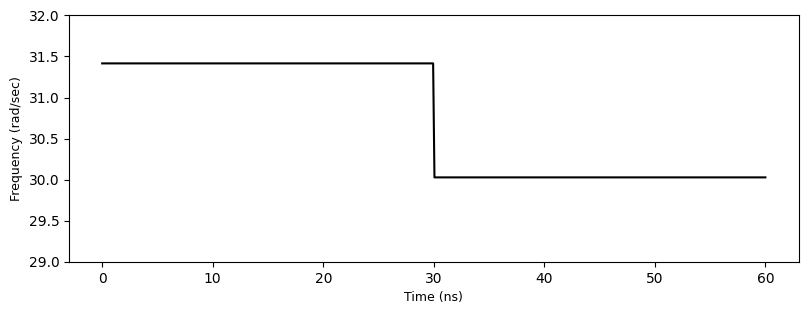

In [8]:
def step_t(w1, w2, t0, width, t):
    """
    Step function that goes from w1 to w2 at time t0
    as a function of t. 
    """
    return w1 + (w2 - w1) * (t > t0)


fig, axes = plt.subplots(1, 1, figsize=(8,3))
axes.plot(tlist, [step_t(w1, w2, T0, 0.0, t) for t in tlist], 'k')
fig.tight_layout()
axes.set_ylim(29, 32) 
axes.set_xlabel("Time (ns)", fontsize=9)
axes.set_ylabel("Frequency (rad/sec)", fontsize=9)

Ideal two-qubit iSWAP gate

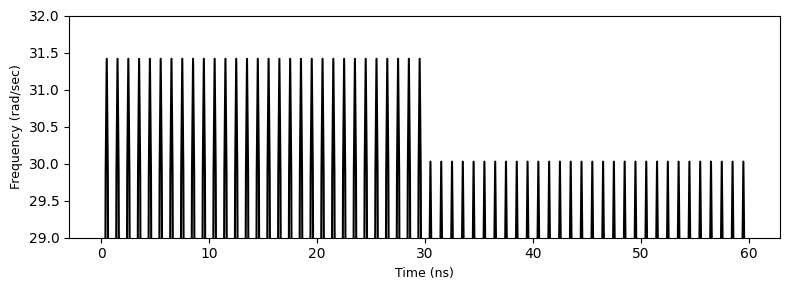

In [9]:


# # def continuous_sine_wave(duration, sampling_rate, frequency):
# #     """
# #     Generate a continuous sine wave with amplitudes given by the step function.

# #     Parameters:
# #     - duration: The total duration of the sine wave.
# #     - sampling_rate: The sampling rate for generating the time points.
# #     - frequency: The frequency of the sine wave.
# #     - step_function_params: Parameters for the step function (w1, w2, t0, width).

# #     Returns:
# #     - t_values: Time values.
# #     - wave_values: Sine wave values with step function amplitudes.
# #     """

# #     t_values = np.linspace(0, duration, int(duration * sampling_rate), endpoint=False)
# #     step_amplitudes = step_t(0.5, 1.5, 50, 0.0, np.atleast_1d(t_values))
# #     wave_values = np.abs(step_amplitudes * np.sin(2 * np.pi * frequency * t_values / duration))

# #     return np.atleast_1d(wave_values)


def delta(w1, w2, t0, width, duration, frequency, t):
    """
    Generate a continuous sine wave with amplitudes given by the step function.

    Parameters:
    - w1: Initial amplitude.
    - w2: Final amplitude.
    - t0: Time at which the transition occurs.
    - width: Width of the step function.
    - duration: The total duration of the sine wave.
    - frequency: The frequency of the sine wave.
    - t: Time value.

    Returns:
    - wave_value: Sine wave value with step function amplitude at the given time.
    """

    step_amplitude = step_t(w1, w2, t0, width, t)
    wave_value = np.abs(step_amplitude * np.sin(2 * np.pi * frequency * t / duration))
    # print(np.atleast_1d(wave_value).shape)
    return np.atleast_1d(wave_value)

# Example usage:
total_duration = 60
sampling_rate = 10 #30
frequency = 30#100
t_values = np.linspace(0, total_duration, int(total_duration * sampling_rate), endpoint=False)

fig, axes = plt.subplots(1, 1, figsize=(8,3))
res = [delta(w1, w2, T0, width, total_duration, frequency, t) for t in t_values]
axes.set_ylim(29, 32) 
axes.plot(t_values, res , 'k')
axes.set_xlabel("Time (ns)", fontsize=9)
axes.set_ylabel("Frequency (rad/sec)", fontsize=9)
fig.tight_layout()


In [10]:

# def delta(w1, w2, t0, width, t_list):
#     return np.atleast_1d([w1 if t < t0 else w2 for t in np.atleast_1d(t_list)])

# # Example usage:
# tlist = np.linspace(0, 100, 500)

# plt.figure(2)
# ylist = delta(0.5, 1.5, 50, 0.0, tlist)
# print(len(ylist))
# markerline, stemlines, baseline = plt.stem(tlist, ylist, '--')
# plt.setp(stemlines, 'color', 'c', 'linewidth', 2)
# plt.setp(baseline, 'color', 'b', 'linewidth', 0.5)
# plt.ylim([-0.5, 2.5])
# plt.xlim([0, 100])

# plt.show()



In [11]:
def wc_del(t, args=None):
    return wc

def w1_del(t, args=None):
    return w1 + delta(0.0, wc-w1, T0_1, width, total_duration, frequency, t) - delta(0.0, wc-w1, T0_1+T_gate_1, width, total_duration, frequency, t)

def w2_del(t, args=None):
    return w2 + delta(0.0, wc-w2, T0_2, width, total_duration, frequency, t) - delta(0.0, wc-w2, T0_2+T_gate_2, width, total_duration, frequency, t)


H_t_del = [[Hc, wc_del], [H1, w1_del], [H2, w2_del], Hc1+Hc2]

# def wc_del(t, args=None):
#     return wc

# def w1_del(t, args=None):
#     return w1 + delta(0.0, wc-w1, T0_1, width, t) - delta(0.0, wc-w1, T0_1+T_gate_1, width, t)

# def w2_del(t, args=None):
#     return w2 + delta(0.0, wc-w2, T0_2, width, t) - delta(0.0, wc-w1, T0_2+T_gate_2, width, t)


# H_t_del = [[Hc, wc_del], [H1, w1_del], [H2, w2_del], Hc1+Hc2]

In [12]:

def wc_t(t, args=None):
    return wc

def w1_t(t, args=None):
    return w1 + step_t(0.0, wc-w1, T0_1, width, t) - step_t(0.0, wc-w1, T0_1+T_gate_1, width, t)

def w2_t(t, args=None):
    return w2 + step_t(0.0, wc-w2, T0_2, width, t) - step_t(0.0, wc-w2, T0_2+T_gate_2, width, t)


H_t = [[Hc, wc_t], [H1, w1_t], [H2, w2_t], Hc1+Hc2]

Evolve the system

In [13]:

res = mesolve(H_t, psi0, tlist, [], [])
res_del = mesolve(H_t_del, psi0, tlist, [], [])

Plot the results

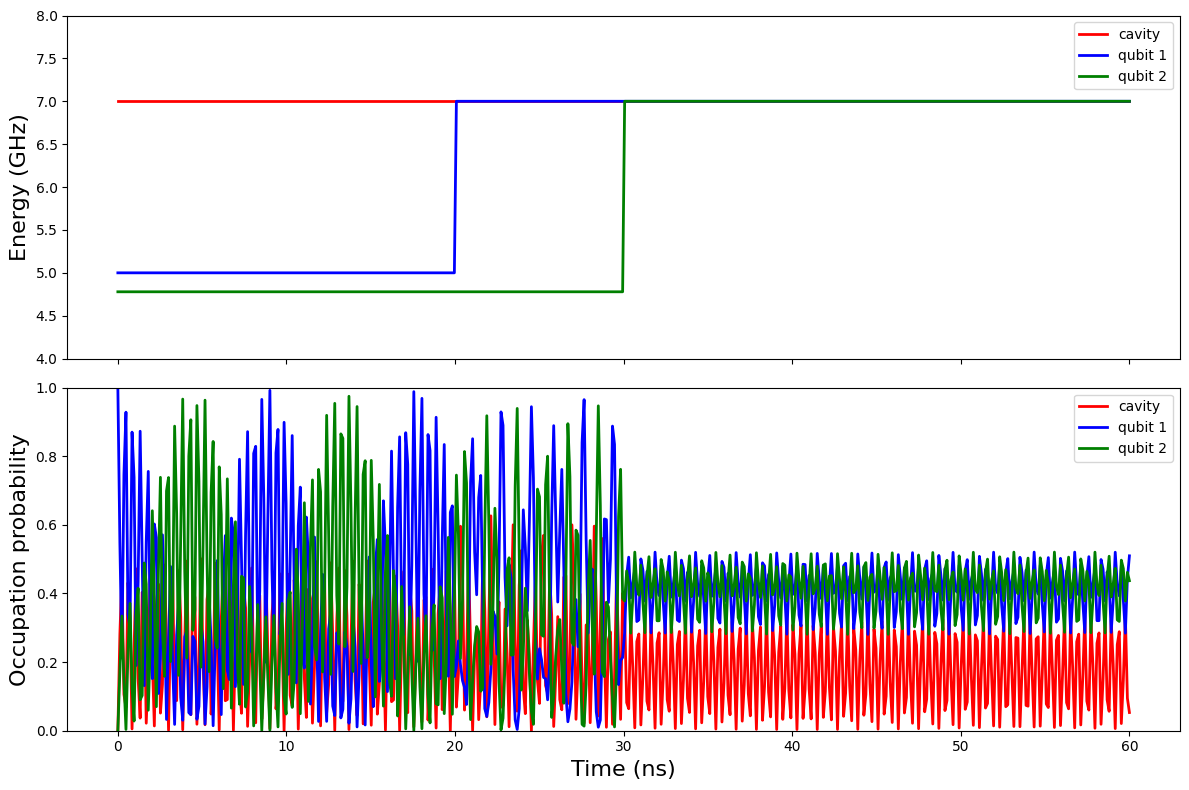

In [14]:
from qutip import Qobj
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, np.array(list(map(wc_t, tlist))) / (2*math.pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, np.array(list(map(w1_t, tlist))) / (2*math.pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, np.array(list(map(w2_t, tlist))) / (2*math.pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(4, 8)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, np.real(expect(Qobj(n), res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, np.real(expect(Qobj(n1), res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, np.real(expect(Qobj(n2), res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

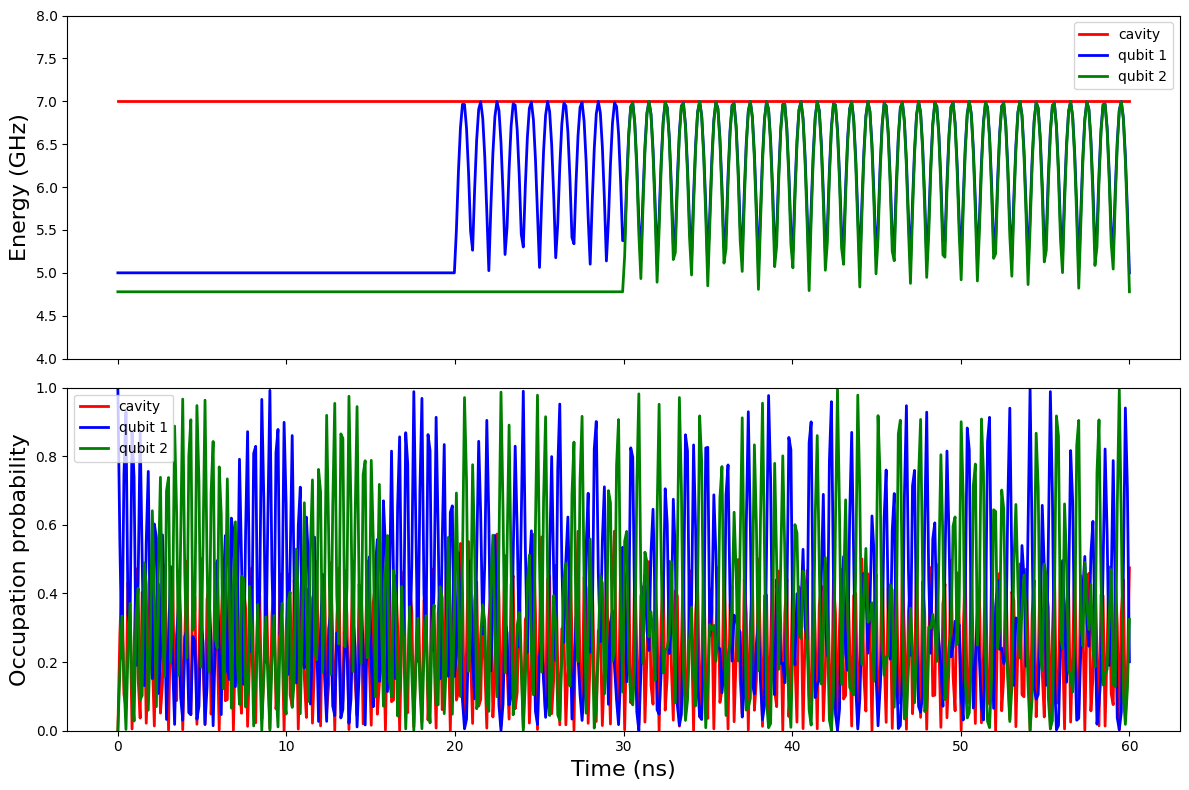

In [15]:
from qutip import Qobj
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, np.array(list(map(wc_del, tlist))) / (2*math.pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, np.array(list(map(w1_del, tlist))) / (2*math.pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, np.array(list(map(w2_del, tlist))) / (2*math.pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(4, 8)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, np.real(expect(Qobj(n), res_del.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, np.real(expect(Qobj(n1), res_del.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, np.real(expect(Qobj(n2), res_del.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

In [16]:
#Finite pulse rise time and dissipation
# increase the pulse rise time a bit
width = 0.6

# high-Q resonator but dissipative qubits
kappa  = 0.0001
gamma1 = 0.005
gamma2 = 0.005

c_ops = [math.sqrt(kappa) * a, math.sqrt(gamma1) * sm1, math.sqrt(gamma2) * sm2]

In [17]:
res_new = mesolve(H_t, psi0, tlist, c_ops, [])
res_del_new = mesolve(H_t_del, psi0, tlist, c_ops, [])

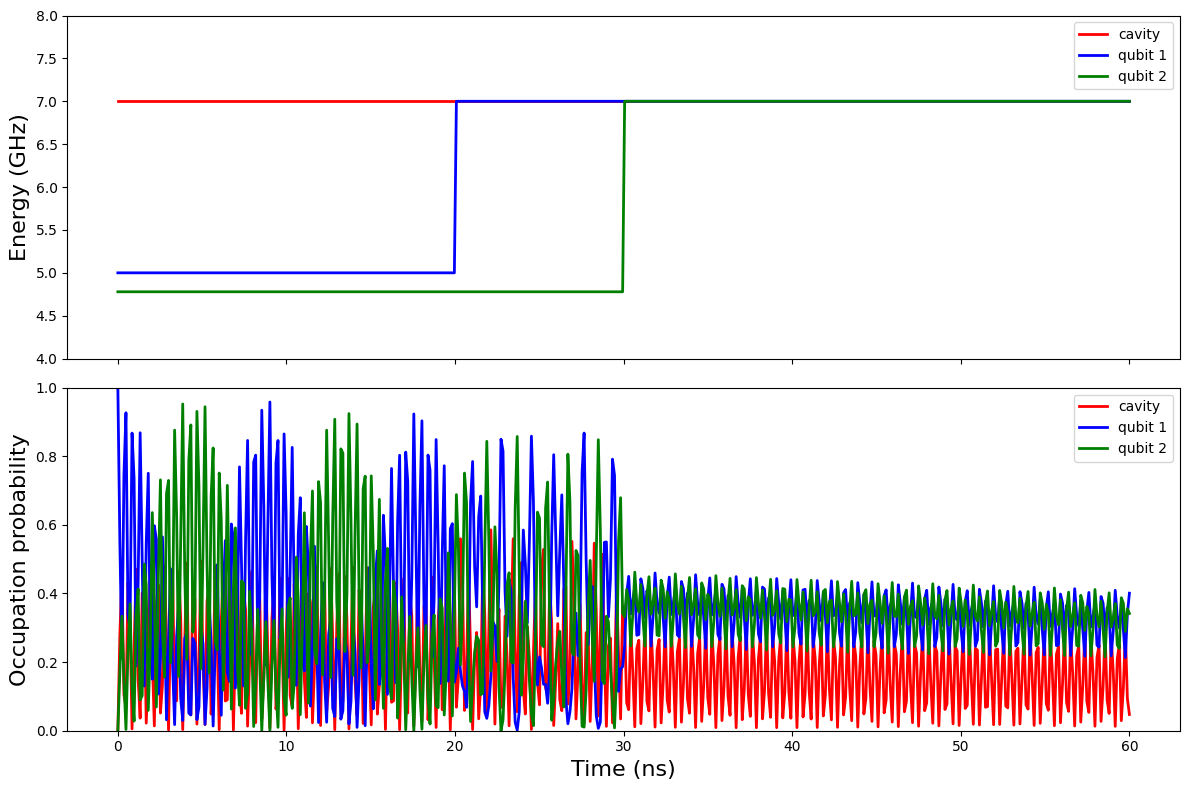

In [18]:
from qutip import Qobj
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, np.array(list(map(wc_t, tlist))) / (2*math.pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, np.array(list(map(w1_t, tlist))) / (2*math.pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, np.array(list(map(w2_t, tlist))) / (2*math.pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(4, 8)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, np.real(expect(Qobj(n), res_new.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, np.real(expect(Qobj(n1), res_new.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, np.real(expect(Qobj(n2), res_new.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

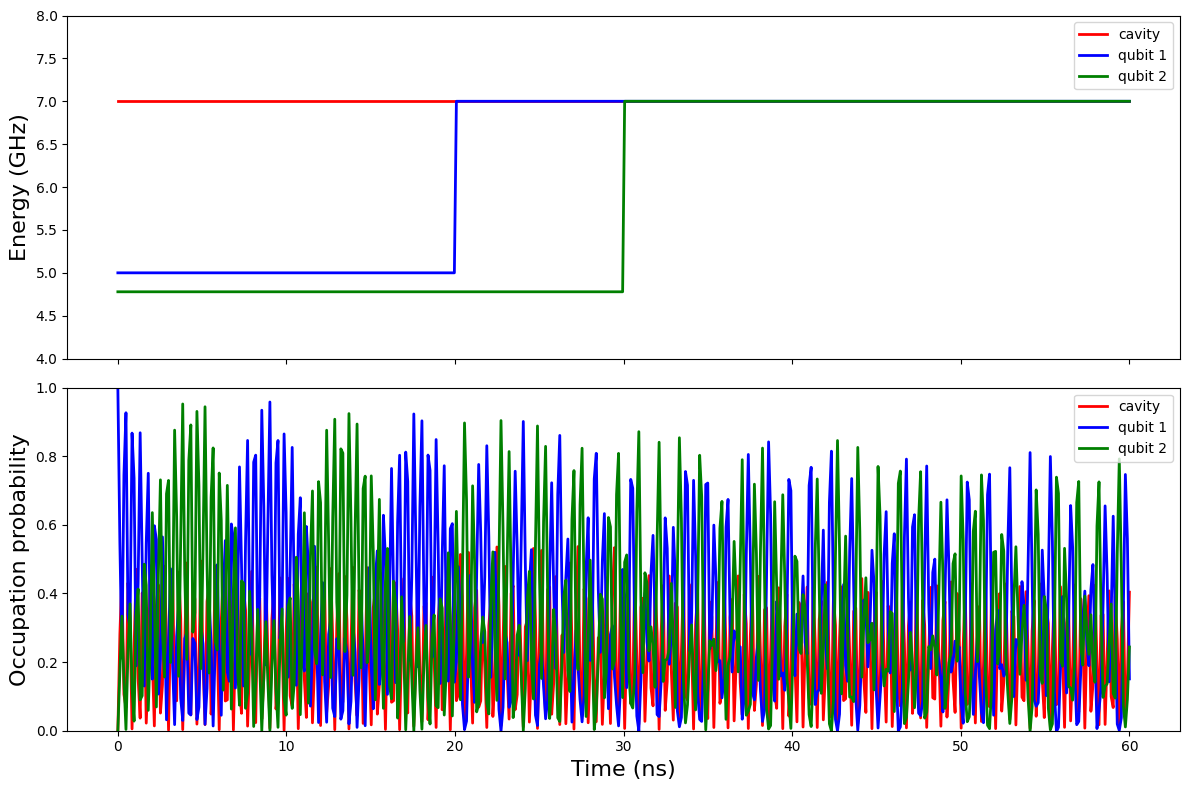

In [19]:
from qutip import Qobj
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, np.array(list(map(wc_t, tlist))) / (2*math.pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, np.array(list(map(w1_t, tlist))) / (2*math.pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, np.array(list(map(w2_t, tlist))) / (2*math.pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(4, 8)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, np.real(expect(Qobj(n), res_del_new.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, np.real(expect(Qobj(n1), res_del_new.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, np.real(expect(Qobj(n2), res_del_new.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

Inspect the final state

In [20]:

# extract the final state from the result of the simulation
rho_final = res.states[-1]
rho_del_final = res_del.states[-1]

In [21]:

# trace out the resonator mode and print the two-qubit density matrix
rho_qubits = ptrace(rho_final, [1,2])
rho_qubits


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.0530434 +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.4372111 +0.j         -0.18318848-0.43509582j
   0.        +0.j        ]
 [ 0.        +0.j         -0.18318848+0.43509582j  0.50974551+0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]]

In [22]:
rho_del_qubits = ptrace(rho_del_final, [1,2])
rho_del_qubits

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.47478642+0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.32427524+0.j         -0.25331238-0.03149862j
   0.        +0.j        ]
 [ 0.        +0.j         -0.25331238+0.03149862j  0.20093833+0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]]

In [23]:

# compare to the ideal result of the sqrtiswap gate (plus phase correction) for the current initial state
rho_qubits_ideal = ket2dm(tensor(phasegate(0), phasegate(-math.pi/2)) * sqrtiswap() * tensor(basis(2,1), basis(2,0)))
rho_qubits_ideal

C:\Users\charu\AppData\Local\Temp\ipykernel_1268\111273819.py:2: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  rho_qubits_ideal = ket2dm(tensor(phasegate(0), phasegate(-math.pi/2)) * sqrtiswap() * tensor(basis(2,1), basis(2,0)))


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.  0.  0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.  0. ]]

Fidelity and concurrence

In [24]:
print("Fidelity for step function:", fidelity(rho_qubits, rho_qubits_ideal))
print("Fidelity for delta function:", fidelity(rho_del_qubits, rho_qubits_ideal))

Fidelity for step function: 0.5387855122448366
Fidelity for delta function: 0.09640749133884087


In [25]:
print("Concurrence for step function:", concurrence(rho_qubits))
print("Concurrence for delta function:", concurrence(rho_del_qubits))

Concurrence for step function: 0.9441745364042792
Concurrence for delta function: 0.5105264963951234
